(sentinel-1)=
# Sentinel-1 RTC

## Product description

The Sentinel-1 Radiometric Terrain Corrected (RTC) data product available in the 
SALDi Data Cube (SDC) is a mirror of [Digital Earth Africa](https://www.digitalearthafrica.org/)'s 
product of the same name. 

Detailed information can be found [here](https://registry.opendata.aws/deafrica-sentinel-1/).

The product abbreviation used in this package is `s1_rtc`

## Loading data

In [3]:
import numpy as np
from matplotlib import pyplot as plt

from sdc.load import load_product

ds = load_product(product="s1_rtc",
                  vec="site06", 
                  time_range=("2021-01-01", "2022-01-01"))
ds

[WARNING] Loading data for an entire SALDi site will likely result in performance issues as it will load data from multiple tiles. Only do so if you know what you are doing and have optimized your workflow! It is recommended to start with a small subset to test your workflow before scaling up.


<xarray.Dataset> Size: 98GB
Dimensions:      (latitude: 5500, longitude: 6500, time: 211)
Coordinates:
  * latitude     (latitude) float64 44kB -24.9 -24.9 -24.9 ... -26.0 -26.0 -26.0
  * longitude    (longitude) float64 52kB 30.75 30.75 30.75 ... 32.05 32.05
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2021-01-01T03:17:55.709725 ... 202...
Data variables:
    vv           (time, latitude, longitude) float32 30GB dask.array<chunksize=(211, 563, 563), meta=np.ndarray>
    vh           (time, latitude, longitude) float32 30GB dask.array<chunksize=(211, 563, 563), meta=np.ndarray>
    area         (time, latitude, longitude) float32 30GB dask.array<chunksize=(211, 563, 563), meta=np.ndarray>
    angle        (time, latitude, longitude) uint8 8GB dask.array<chunksize=(211, 1127, 1127), meta=np.ndarray>

Exactly as the example in the {ref}`sentinel-2` notebook, we have now _lazily_ loaded 
Sentinel-1 RTC data. If you are not familiar with the concept of lazy loading, please 
refer to {ref}`xarray-dask-intro` and the {ref}`sentinel-2` notebook. The latter also 
covers some Xarray basics (Look for the “Xarray Shorts” sections), so be sure to check 
it out if you haven’t already!

Let's have a closer look at the `vh`-band (vertical transmit, horizontal receive):

In [6]:
ds.vh

<xarray.DataArray 'vh' (time: 211, latitude: 5500, longitude: 6500)> Size: 30GB
dask.array<vh, shape=(211, 5500, 6500), dtype=float32, chunksize=(211, 563, 563), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 44kB -24.9 -24.9 -24.9 ... -26.0 -26.0 -26.0
  * longitude    (longitude) float64 52kB 30.75 30.75 30.75 ... 32.05 32.05
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2021-01-01T03:17:55.709725 ... 202...
Attributes:
    nodata:   nan

## Converting to decibel scale

With Synthetic Aperture Radar (SAR) data, it is often useful to convert the data 
to decibel (dB) scale for visualization purposes. The Sentinel-1 RTC data here is stored 
in power (linear) scale by default and can be converted to decibel scale using numpy's 
[`log10`-method](https://numpy.org/doc/stable/reference/generated/numpy.log10.html#numpy.log10) 
and multiply the result by `10`:

In [4]:
vh_db = 10 * np.log10(ds.vh)
vh_db

<xarray.DataArray 'vh' (time: 211, latitude: 5500, longitude: 6500)> Size: 30GB
dask.array<mul, shape=(211, 5500, 6500), dtype=float32, chunksize=(211, 563, 563), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 44kB -24.9 -24.9 -24.9 ... -26.0 -26.0 -26.0
  * longitude    (longitude) float64 52kB 30.75 30.75 30.75 ... 32.05 32.05
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2021-01-01T03:17:55.709725 ... 202...
Attributes:
    nodata:   nan

```{warning}
Due to the logarithmic nature of the decibel scale, it is not appropriate for some 
mathematical operations. For example, the mean of decibel data is not the same as
the mean of the data in power (linear) scale. It is recommended to keep the data 
in power (linear) scale for your analysis and only convert to decibel scale for
visualization purposes in the end.
```

```{tip}
The [SAR Handbook](https://servirglobal.net/resources/sar-handbook) is a great resource 
on topics related to SAR data processing and interpretation. Regarding power vs decibel 
scale, have a closer look at [Chapter 3 Tutorial](https://gis1.servirglobal.net/TrainingMaterials/SAR/3B_TrainingModule.pdf) 
and the sections "Comparing histograms of the amplitude, power, and dB scaled data" 
(p. 92) and "Why is the scale important?" (p. 93) in particular.
```

Notice how the data structure above is still the same as for the 
`vh`-band we started with and that the data is still lazily loaded. The only 
difference is the increase of graph layers in the row called "Dask graph". Dask 
is constructing a graph behind the scenes, which is a representation of the 
computation that will be executed once the data is loaded into memory. 

To see the difference between the power and the decibel scaled data, let's plot the time 
series of {ref}`xarray-shorts-1` again:

In [8]:
px_water = (31.571, -24.981)
px_veg1 = (31.5384, -25.0226)
px_veg2 = (31.551, -25.034)

vh_px_water = ds.vh.sel(longitude=px_water[0], latitude=px_water[1], method="nearest")
vh_px_veg1 = ds.vh.sel(longitude=px_veg1[0], latitude=px_veg1[1], method="nearest")
vh_px_veg2 = ds.vh.sel(longitude=px_veg2[0], latitude=px_veg2[1], method="nearest")

vh_db_px_water = vh_db.sel(longitude=px_water[0], latitude=px_water[1], method="nearest")
vh_db_px_veg1 = vh_db.sel(longitude=px_veg1[0], latitude=px_veg1[1], method="nearest")
vh_db_px_veg2 = vh_db.sel(longitude=px_veg2[0], latitude=px_veg2[1], method="nearest")

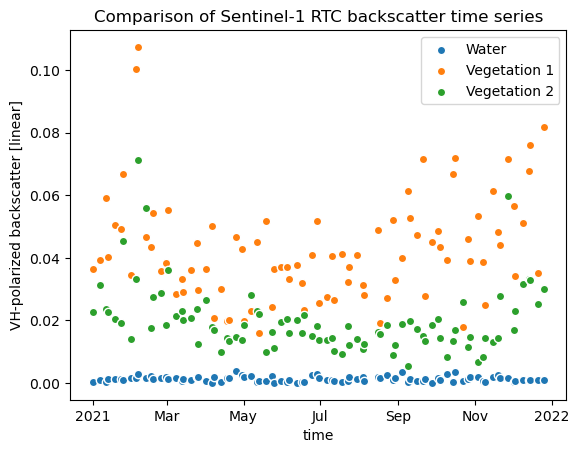

In [9]:
vh_px_water.plot.scatter(x="time", label="Water")
vh_px_veg1.plot.scatter(x="time", label="Vegetation 1")
vh_px_veg2.plot.scatter(x="time", label="Vegetation 2")
plt.title("Comparison of Sentinel-1 RTC backscatter time series")
plt.ylabel("VH-polarized backscatter [linear]")
plt.legend()

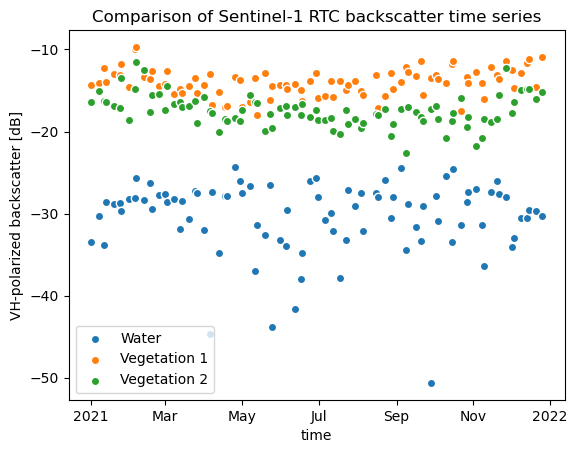

In [10]:
vh_db_px_water.plot.scatter(x="time", label="Water")
vh_db_px_veg1.plot.scatter(x="time", label="Vegetation 1")
vh_db_px_veg2.plot.scatter(x="time", label="Vegetation 2")
plt.title("Comparison of Sentinel-1 RTC backscatter time series")
plt.ylabel("VH-polarized backscatter [dB]")
plt.legend()

(xarray-shorts-4)=
## Xarray Shorts: Groupby-operations

Combining [`groupby`-operations](https://docs.xarray.dev/en/stable/user-guide/groupby.html) 
with aggregation functions can be very useful to calculate statistics for 
different time periods. In the following example, we calculate the median for 
each month of the year.

Let's first just apply the groupby-operation. The result is a `xarray.core.groupby.DataArrayGroupBy`
object, which is a lazy representation of the grouped data.

In [5]:
vh_monthly = ds.vh.groupby("time.month")
vh_monthly

<DataArrayGroupBy, grouped over 1 grouper(s), 12 groups in total:
    'month': 12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12>

```{tip}
Handling Xarray's datetime components as in the example above can be very useful. 
You can find an overview on this topic [here](https://docs.xarray.dev/en/stable/user-guide/time-series.html#datetime-components).
```

We can now apply an aggregation function to the grouped data. In this case, we 
calculate the median for each month of the year. The result is a 
`xarray.DataArray` object with a new `month`-dimension. 

Notice that the size of the array is now much smaller than the original `vh` 
data we started with because we have reduced the number of time steps from 211 
(acquisitions) to 12 (months). The size is an estimate of the potential memory 
footprint of the data.

In [6]:
vh_monthly_median = vh_monthly.median(dim="time")
vh_monthly_median

<xarray.DataArray 'vh' (month: 12, latitude: 5500, longitude: 6500)> Size: 2GB
dask.array<stack, shape=(12, 5500, 6500), dtype=float32, chunksize=(1, 563, 563), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float64 44kB -24.9 -24.9 -24.9 ... -26.0 -26.0 -26.0
  * longitude    (longitude) float64 52kB 30.75 30.75 30.75 ... 32.05 32.05
    spatial_ref  int32 4B 4326
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    nodata:   nan

We could have also chained both operations together, which would have resulted 
in the same output:

```python
vh_monthly_median = ds.vh.groupby("time.month").median(dim="time")
```

You can find an overview of which methods are available for grouped 
`DataArrayGroupBy` objects [here](https://docs.xarray.dev/en/stable/api.html#id14).



As you can probably imagine, these operations can be very useful to handle and 
analyse large time series data. Instead of going further at this point, let's 
just convert the result to decibel scale, select the month of June and plot it: 

Text(0.5, 1.0, 'Median VH-polarized backscatter for June 2021; SALDi site 06')

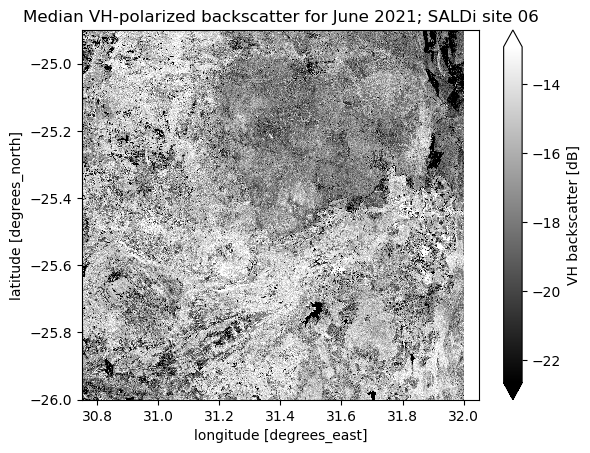

In [9]:
vh_monthly_median_db = 10 * np.log10(vh_monthly_median)
vh_monthly_median_db.sel(month=6).plot(robust=True, cmap="gray", cbar_kwargs={"label": "VH backscatter [dB]"})
plt.title("Median VH-polarized backscatter for June 2021; SALDi site 06")